In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from  matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
# set paths of the data files
PATH_S = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/hist_salaries.csv'
PATH_R = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/rookies.csv'
PATH_RS = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/agg_df_stats.csv'

In [26]:
# get the salary and stats data
df_stats = pd.read_csv(PATH_RS, index_col = 0)
df_salary = pd.read_csv(PATH_S, index_col = 0)

In [27]:
# need to get the inner join of salary and stats
print(df_stats.shape)
print(df_salary.shape)

(2467, 20)
(1712, 9)


In [28]:
df_stats.head()

,Year,Age,name,debut,position,G,PA,AB,R,H,SB,BA,HR,TB,2B,3B,RBI,BB,SO,name_year
0,1985,21.0,Denny Gonzalez,1984-08-06,"Third Baseman, Shortstop and Leftfielder",35.0,138.0,124.0,11.0,28.0,2.0,0.226,4.0,44.0,4.0,0.0,12.0,13.0,27.0,Denny Gonzalez_1985
1,1985,21.0,Ozzie Guillen,1985-04-09,Shortstop,150.0,513.0,491.0,71.0,134.0,7.0,0.273,1.0,176.0,21.0,9.0,33.0,12.0,36.0,Ozzie Guillen_1985
2,1985,21.0,Sam Khalifa,1985-06-25,Shortstop and Second Baseman,95.0,367.0,320.0,30.0,76.0,5.0,0.238,2.0,102.0,14.0,3.0,31.0,34.0,56.0,Sam Khalifa_1985
3,1985,22.0,Daryl Boston,1984-05-13,Outfielder,95.0,248.0,232.0,20.0,53.0,8.0,0.228,3.0,77.0,13.0,1.0,15.0,14.0,44.0,Daryl Boston_1985
4,1985,22.0,Lenny Dykstra,1985-05-03,Centerfielder,83.0,273.0,236.0,40.0,60.0,15.0,0.254,1.0,78.0,9.0,3.0,19.0,30.0,24.0,Lenny Dykstra_1985


In [29]:
df_salary.head()

,Year,Age,name,UID,rookie_year,name_year,Salary,SrvTm,today_salary
0,1991,27.0,Ozzie Guillen,40,1985,Ozzie Guillen_1985,1600000.0,0.0,2.879530e+06
1,1991,28.0,Daryl Boston,7,1985,Daryl Boston_1985,750000.0,0.0,1.349780e+06
2,1991,28.0,Lenny Dykstra,30,1985,Lenny Dykstra_1985,2216666.0,0.0,3.989348e+06
3,1991,28.0,Mariano Duncan,28,1985,Mariano Duncan_1985,925000.0,0.0,1.664728e+06
4,1991,28.0,Shawon Dunston,29,1985,Shawon Dunston_1985,2100000.0,0.0,3.779383e+06


In [30]:
df_stats.name_year.value_counts().head()

Keith Miller_1989        2
Daryl Boston_1985        1
Wilin Rosario_2012       1
Nick Johnson_2002        1
Michael Brantley_2010    1
Name: name_year, dtype: int64

There are two Keith Millers that had a rookie season in 1989. However, they both did not have 6 seasons in the MLB past their rookie season. Thus, they will be excluded when the two data sets are joined.

In [32]:
salary_stats_df = df_stats.merge(df_salary, on='name_year')
salary_stats_df = salary_stats_df.loc[:,['Year_x', 'Age_x', 'name_x', 'debut', 'position', 'G', 'PA', 'AB', 'R',
       'H', 'SB', 'BA', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'name_year',
        'Salary', 'SrvTm', 'today_salary']]
salary_stats_df.rename(columns={'Year_x':'rookie_year', 'Age_x':'age', 'name_x':'name'}, inplace=True)
salary_stats_df['log_today_salary'] = np.log10(salary_stats_df.today_salary)
salary_stats_df.shape

(919, 24)

In [33]:
y = salary_stats_df.log_today_salary

# May need to take BA out
X = salary_stats_df.loc[:,['G', 'PA', 'AB', 'R', 'H', 'SB', 'BA', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO']]
print(X.shape)
print(y.shape)

(919, 14)
(919,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

X_train.shape

(735, 14)

* Distribution of log(salary) is somewhat normal. Need to confirm if this is OK or not.
* Should put age into feature set and see if the younger the rookie then better chance of a higher salary.
* Need some type of pairplot as probably some of my features are correlated like HRs and TBs.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


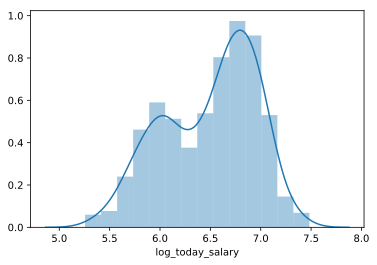

In [35]:
sns.distplot(y_train);

In [36]:
lin_model = LinearRegression()
lin_fit = lin_model.fit(X_train,y_train)
lin_fit.score(X_train, y_train)

0.18900764298468054

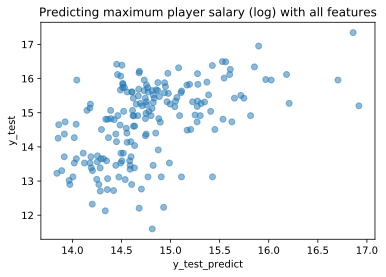

In [14]:
# plt.scatter(X_train, y_train)
plt.scatter(lin_model.predict(X_test),y_test, alpha=0.5)
plt.xlabel('y_test_predict')
plt.ylabel('y_test')
plt.title('Predicting maximum player salary (log) with all features');

In [18]:
corr = pd.concat([X_train, y_train], axis=1).corr()
corr.Salary.sort_values(ascending=False)

Salary    1.000000
HR        0.349057
TB        0.333231
RBI       0.331960
R         0.311324
SO        0.299686
2B        0.299001
H         0.282569
PA        0.264969
AB        0.262431
BB        0.242276
3B        0.191497
G         0.158919
BA        0.119072
SB        0.115762
Name: Salary, dtype: float64